# Use NEWT for indoor WBGT calculation

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy

import numpy as np
import pandas as pd
import os, glob, re, sys
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
import netCDF4

%matplotlib inline

In [3]:
# NEWT (used in paper) 
sys.path.append('../atmos/')
import atmos
from atmos import thermo

In [3]:
from settings import *
figdir = os.path.join(figdirs, 'fig_feb25')


In [4]:
# heat stress package from Schwingshackl, 2021 (not used in paper)
sys.path.append('../CDS_heat_stress_indicators/')
import calc_heat_stress_indicators as hsi

In [5]:
print(thermo.pseudo_wet_bulb_temperature.__doc__)
print(thermo.isobaric_wet_bulb_temperature.__doc__)


    Computes pseudo wet-bulb temperature.

    Pseudo wet-bulb temperature is the temperature of a parcel of air lifted
    adiabatically to saturation and then brought pseudoadiabatically at
    saturation back to its original pressure. It is always less than the
    isobaric wet-bulb temperature.

    See https://glossary.ametsoc.org/wiki/Wet-bulb_temperature.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        polynomial (bool, optional): flag indicating whether to use polynomial
            fits to pseudoadiabats (default is True)

    Returns:
        Tw (float or ndarray): pseudo wet-bulb temperature (K)

    

    Computes isobaric wet-bulb temperature.

    Isobaric wet-bulb temperature is the temperature of a parcel of air cooled
   

In [6]:
print(thermo.wet_bulb_temperature.__doc__)



    Computes wet-bulb temperature for specified saturation process.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        saturation (str, optional): saturation process (valid options are
            'pseudo' or 'isobaric'; default is 'pseudo')
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        polynomial (bool, optional): flag indicating whether to use polynomial
            fits to pseudoadiabats (default is True)

    Returns:
        Tw: wet-bulb temperature (K)

    


In [7]:
print(thermo.relative_humidity.__doc__)



    Computes relative humidity with respect to specified phase from pressure, 
    temperature, and specific humidity.

    Args:
        p (float or ndarray): pressure (Pa)
        T (float or ndarray): temperature (K)
        q (float or ndarray): specific humidity (kg/kg)
        qt (float or ndarray, optional): total water mass fraction (kg/kg)
            (default is None, which implies qt = q)
        phase (str, optional): condensed water phase (valid options are
            'liquid', 'ice', or 'mixed'; default is 'liquid')
        omega (float or ndarray, optional): ice fraction at saturation 
            (default is 0.0)
        
    Returns:
        RH (float or ndarray): relative humidity (fraction)

    


# Test run Tw calculation (isobaric)

Not what I will use

In [8]:
thermo.wet_bulb_temperature(1030*100,30+273.15,.008, saturation ='isobaric') - 273.15

18.373963931812114

In [9]:
p = 1000 * 100 # Pascals
T = np.arange(20,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) 

len(T), len(q)

(60, 49)

In [10]:
T_arr = np.array([T]*len(q) ) 
T_arr

array([[293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       ...,
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65]])

In [11]:
q_arr = np.array([q]*len(T) ).T
q_arr

array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])

In [12]:
RH_arr = thermo.relative_humidity(p, T_arr, q_arr)
RH_arr

array([[0.0687042 , 0.06661227, 0.06459171, ..., 0.01401418, 0.01366764,
        0.01333085],
       [0.13732496, 0.13314364, 0.12910496, ..., 0.02801134, 0.02731868,
        0.02664551],
       [0.20586243, 0.19959425, 0.19353991, ..., 0.04199152, 0.04095315,
        0.03994401],
       ...,
       [3.14129326, 3.04564588, 2.95326162, ..., 0.64075639, 0.62491171,
        0.60951307],
       [3.20623401, 3.10860929, 3.01431514, ..., 0.65400291, 0.63783067,
        0.62211369],
       [3.27109808, 3.17149835, 3.07529657, ..., 0.66723379, 0.65073437,
        0.63469942]])

In [13]:
print(q_arr.shape, T_arr.shape, RH_arr.shape)

(49, 60) (49, 60) (49, 60)


<a list of 9 text.Text objects>

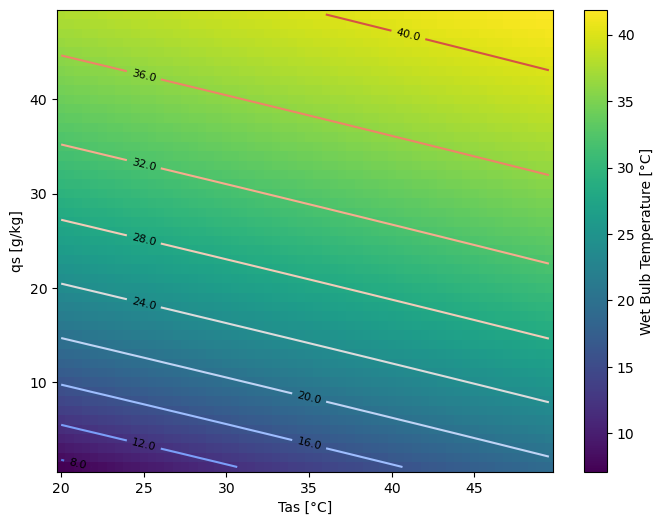

In [14]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,q_arr, saturation ='isobaric') - 273.15

Tw_da = xr.DataArray(Tw_arr, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [15]:
Tw_da_isobaric = Tw_da

In [16]:

WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (qs: 49, Tas: 60)>
array([[10.98004697, 11.3022496 , 11.62322882, ..., 27.72374161,
        27.9934836 , 28.26256355],
       [11.79490711, 12.11072504, 12.42538592, ..., 28.26532986,
        28.5316181 , 28.79728015],
       [12.58008005, 12.88983999, 13.19850701, ..., 28.79141525,
        29.05442054, 29.31683326],
       ...,
       [31.82937939, 32.03437095, 32.23923892, ..., 43.33602353,
        43.53499052, 43.73386787],
       [32.08987093, 32.29402526, 32.4980606 , ..., 43.55519728,
        43.7535401 , 43.95179628],
       [32.34629403, 32.54963659, 32.75286457, ..., 43.77146963,
        43.96920449, 44.16685556]])
Coordinates:
  * qs       (qs) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 45.0 46.0 47.0 48.0 49.0
  * Tas      (Tas) float64 20.0 20.5 21.0 21.5 22.0 ... 47.5 48.0 48.5 49.0 49.5
Attributes:
    units:    °C

<a list of 7 text.Text objects>

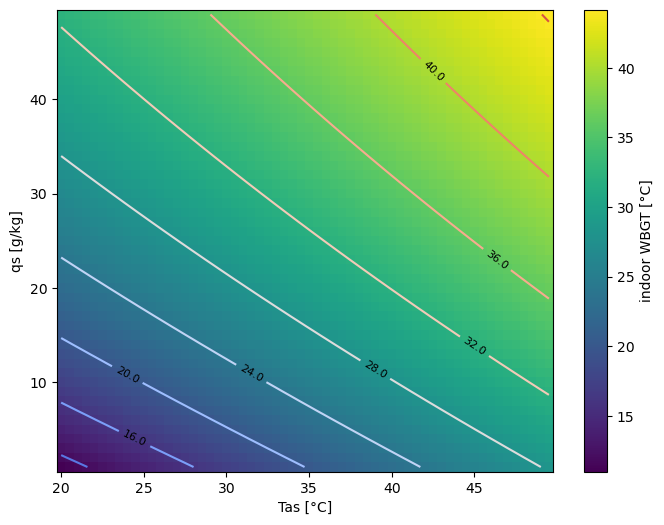

In [17]:

fig, ax = plt.subplots(figsize=(8, 6))


WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.qs, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


# Test run Tw calculation (pseudo-adiabatic)


In [18]:
thermo.wet_bulb_temperature(1030*100,30+273.15,.008, saturation ='pseudo') - 273.15

array([18.14564588])

In [19]:
p = 1000 * 100 # Pascals
T = np.arange(20,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) 

len(T), len(q)

(60, 49)

In [20]:
T_arr = np.array([T]*len(q) ) 
T_arr

array([[293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       ...,
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65]])

In [21]:
q_arr = np.array([q]*len(T) ).T
q_arr

array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])

In [22]:
print(q_arr.shape, T_arr.shape)

(49, 60) (49, 60)


<a list of 9 text.Text objects>

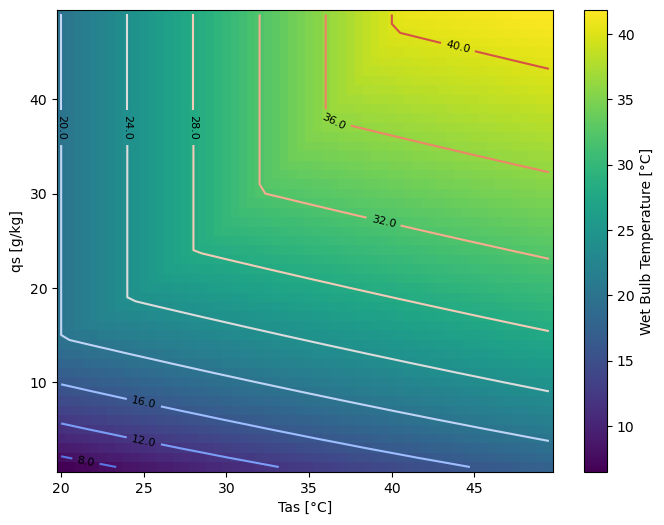

In [23]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,q_arr, saturation ='pseudo') - 273.15

Tw_da = xr.DataArray(Tw_arr, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [24]:
Tw_da_adiabatic = Tw_da

In [25]:

WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (qs: 49, Tas: 60)>
array([[10.54839711, 10.86001043, 11.17031155, ..., 26.56960496,
        26.82490193, 27.07948839],
       [11.47994266, 11.78615186, 12.09109034, ..., 27.25334344,
        27.50529693, 27.75657143],
       [12.34656573, 12.64759626, 12.94741485, ..., 27.89316865,
        28.14214432, 28.3904661 ],
       ...,
       [19.99985063, 20.49980628, 20.99975077, ..., 43.3166142 ,
        43.5132616 , 43.70970406],
       [19.99985063, 20.49980628, 20.99975077, ..., 43.53786603,
        43.73399918, 43.92992866],
       [19.99985063, 20.49980628, 20.99975077, ..., 43.7560457 ,
        43.95167797, 44.14710736]])
Coordinates:
  * qs       (qs) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 45.0 46.0 47.0 48.0 49.0
  * Tas      (Tas) float64 20.0 20.5 21.0 21.5 22.0 ... 47.5 48.0 48.5 49.0 49.5
Attributes:
    units:    °C

<a list of 8 text.Text objects>

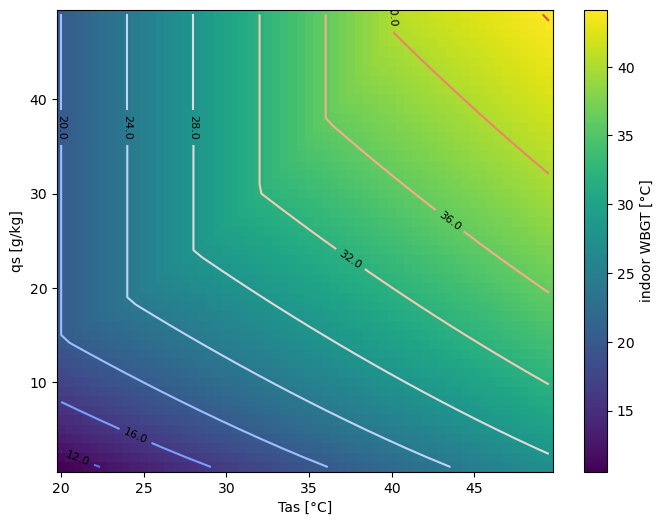

In [26]:

fig, ax = plt.subplots(figsize=(8, 6))


WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.qs, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


# save this fig and put in SI

# Test on a dataarray

In [27]:
# open da tasmax (small subregion) or make dummy dd

# open da qs (small subregion) or make dummy dd

# check / convert units 

# run NEWT on it or make wrapper fxn to do so 

# Test Tw from relative humidity

1. calculate specific humidity (q) from relative humidity (RH)
2. calc Tw from this

In [28]:
p = 1000 * 100 # Pascals
T = np.arange(-20,51,1) + 273.15 # Kelvin
RH = np.arange(0,101,1) # %

len(T), len(RH)

(71, 101)

In [29]:
T_arr = np.array([T]*len(RH) ) 
T_arr

array([[253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       ...,
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15],
       [253.15, 254.15, 255.15, ..., 321.15, 322.15, 323.15]])

In [30]:
RH_arr = np.array([RH]*len(T) ).T
RH_arr

array([[  0,   0,   0, ...,   0,   0,   0],
       [  1,   1,   1, ...,   1,   1,   1],
       [  2,   2,   2, ...,   2,   2,   2],
       ...,
       [ 98,  98,  98, ...,  98,  98,  98],
       [ 99,  99,  99, ...,  99,  99,  99],
       [100, 100, 100, ..., 100, 100, 100]])

In [31]:
print(RH_arr.shape, T_arr.shape)

(101, 71) (101, 71)


In [32]:
es_arr = thermo.saturation_vapour_pressure(T_arr)
es_arr

# saturation vapor pressure (Pa)

array([[  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       ...,
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748],
       [  125.70977236,   136.95326293,   149.09135854, ...,
        11182.65560553, 11757.96974892, 12358.48334748]])

In [33]:
e_arr = RH_arr * (es_arr/100)
e_arr

# actual vapor pressure (Pa)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.25709772e+00, 1.36953263e+00, 1.49091359e+00, ...,
        1.11826556e+02, 1.17579697e+02, 1.23584833e+02],
       [2.51419545e+00, 2.73906526e+00, 2.98182717e+00, ...,
        2.23653112e+02, 2.35159395e+02, 2.47169667e+02],
       ...,
       [1.23195577e+02, 1.34214198e+02, 1.46109531e+02, ...,
        1.09590025e+04, 1.15228104e+04, 1.21113137e+04],
       [1.24452675e+02, 1.35583730e+02, 1.47600445e+02, ...,
        1.10708290e+04, 1.16403901e+04, 1.22348985e+04],
       [1.25709772e+02, 1.36953263e+02, 1.49091359e+02, ...,
        1.11826556e+04, 1.17579697e+04, 1.23584833e+04]])

In [34]:
atmos.constant.eps

0.6218851570964247

In [35]:
# mixing ratio (kg/kg)

r_arr = (atmos.constant.eps * e_arr) / (p - e_arr)
r_arr

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.81780243e-06, 8.51703679e-06, 9.27190853e-06, ...,
        6.96211303e-04, 7.32071454e-04, 7.69506729e-04],
       [1.56358014e-05, 1.70343069e-05, 1.85440935e-05, ...,
        1.39398319e-03, 1.46586850e-03, 1.54092016e-03],
       ...,
       [7.67080016e-04, 8.35779909e-04, 9.09963031e-04, ...,
        7.65404834e-02, 8.09910979e-02, 8.56975627e-02],
       [7.74917116e-04, 8.44319855e-04, 9.19262094e-04, ...,
        7.74187389e-02, 8.19264119e-02, 8.66939325e-02],
       [7.82754414e-04, 8.52860034e-04, 9.28561434e-04, ...,
        7.82992059e-02, 8.28642184e-02, 8.76931123e-02]])

In [36]:
# correct for RH 100% divide by zero

#r_arr[0] = (atmos.constant.eps * es_arr[0]) / (p - es_arr[0])
#r_arr

In [37]:
# specific humidity (kg/kg)

qs_from_RH = r_arr / (1+r_arr)
qs_from_RH

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.81774131e-06, 8.51696425e-06, 9.27182256e-06, ...,
        6.95726930e-04, 7.31535917e-04, 7.68915044e-04],
       [1.56355569e-05, 1.70340167e-05, 1.85437497e-05, ...,
        1.39204271e-03, 1.46372288e-03, 1.53854938e-03],
       ...,
       [7.66492055e-04, 8.35081965e-04, 9.09135751e-04, ...,
        7.10985648e-02, 7.49230017e-02, 7.89331815e-02],
       [7.74317085e-04, 8.43607580e-04, 9.18417827e-04, ...,
        7.18557568e-02, 7.57227210e-02, 7.97776908e-02],
       [7.82142189e-04, 8.52133284e-04, 9.27700008e-04, ...,
        7.26136173e-02, 7.65231845e-02, 8.06230280e-02]])

In [38]:
qs_from_RH.shape

(101, 71)

In [39]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,qs_from_RH, saturation ='pseudo') - 273.15
Tw_arr

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [-21.78980574, -20.92896595, -20.076309  , ...,  16.70325757,
         17.04563655,  17.38461557],
       [-21.76729026, -20.90464921, -20.05008919, ...,  17.41316308,
         17.78110448,  18.14635214],
       ...,
       [-20.03327078, -19.03553133, -18.03790925, ...,  47.64025721,
         48.63819127,  49.63366837],
       [-20.0163508 , -19.01731959, -18.01833346, ...,  47.82010787,
         48.82013614,  49.81628841],
       [-19.99943657, -18.99911484, -17.99876619, ...,  47.99874728,
         49.00070209,  49.99705349]])

<a list of 9 text.Text objects>

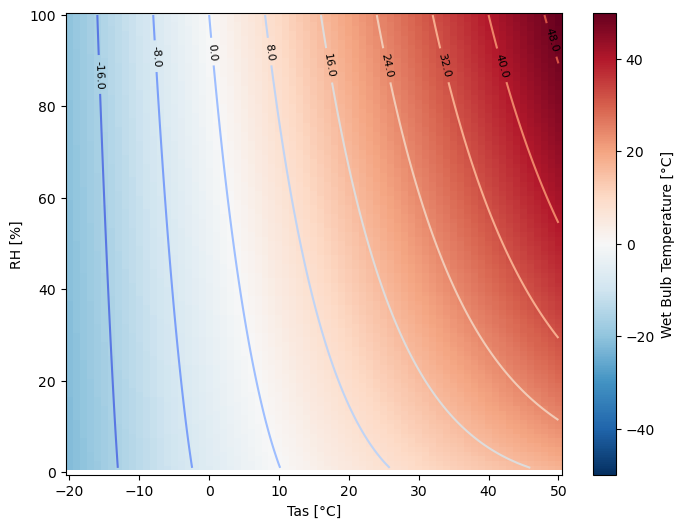

In [40]:
Tw_da = xr.DataArray(Tw_arr, coords=[ ('RH', RH), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['RH'].attrs['units'] = '%'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.RH, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black') 

In [41]:
WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (RH: 101, Tas: 71)>
array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [-21.25286402, -20.35027617, -19.4534163 , ...,  26.0922803 ,
         26.63194558,  27.1692309 ],
       [-21.23710318, -20.33325445, -19.43506243, ...,  26.58921416,
         27.14677313,  27.7024465 ],
       ...,
       [-20.02328955, -19.02487193, -18.02653647, ...,  47.74818005,
         48.74673389,  49.74356786],
       [-20.01144556, -19.01212371, -18.01283342, ...,  47.87407551,
         48.8740953 ,  49.87140189],
       [-19.9996056 , -18.99938039, -17.99913634, ...,  47.9991231 ,
         49.00049146,  49.99793744]])
Coordinates:
  * RH       (RH) int64 0 1 2 3 4 5 6 7 8 9 ... 91 92 93 94 95 96 97 98 99 100
  * Tas      (Tas) float64 -20.0 -19.0 -18.0 -17.0 -16.0 ... 47.0 48.0 49.0 50.0
Attributes:
    units:    °C

<a list of 9 text.Text objects>

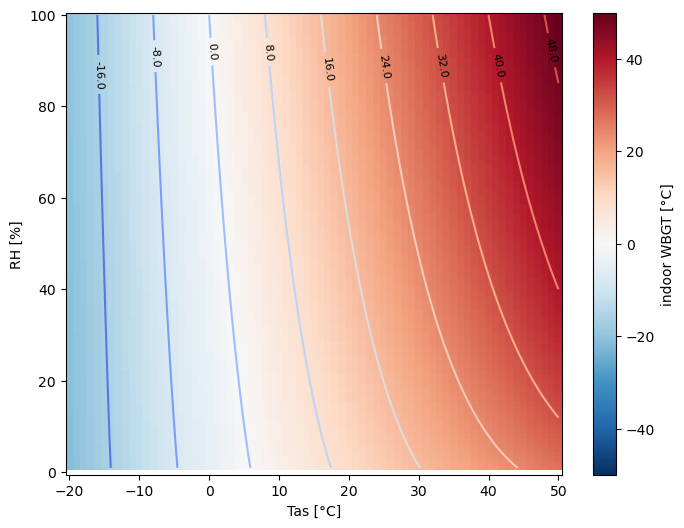

In [42]:

fig, ax = plt.subplots(figsize=(8, 6))

WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.RH, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


Text(0.0, 1.0, 'b')

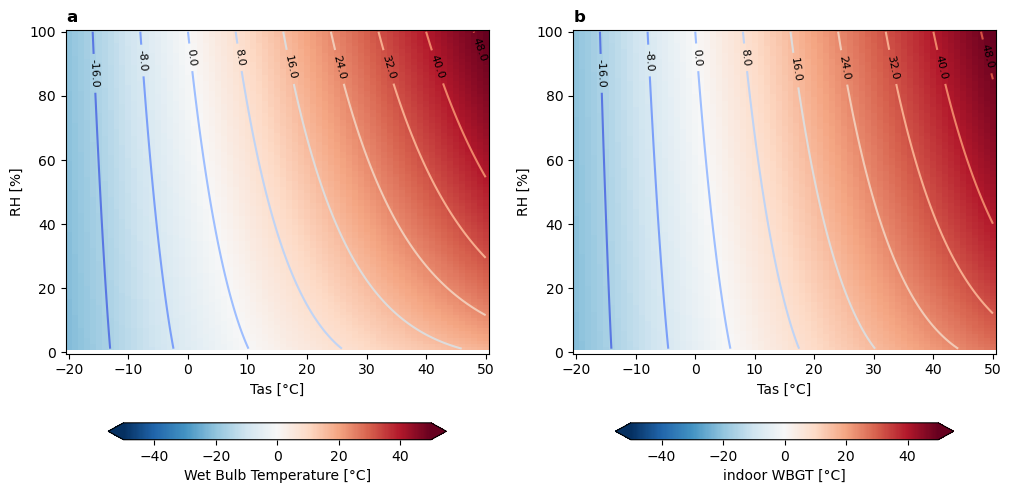

In [43]:
fig, axes = plt.subplots(1,2,figsize=(12, 6))

ax=axes[0]
Tw_da.plot(ax =ax, cbar_kwargs={"orientation": "horizontal", 'extend':'both', 'shrink':0.8} )
contours = ax.contour(Tw_da.Tas, Tw_da.RH, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  
ax.set_title('a',loc='left',fontweight='bold')

ax=axes[1]
WBGT_da.plot(ax =ax, cbar_kwargs={"orientation": "horizontal", 'extend':'both', 'shrink':0.8} )
contours = ax.contour(WBGT_da.Tas, WBGT_da.RH, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  
ax.set_title('b',loc='left',fontweight='bold')



# plt.savefig(os.path.join(figdir, 'figSI_NEWT.png'), dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(figdir, 'figSI_NEWT.pdf'), dpi=300, bbox_inches='tight', transparent=True)

# Compare with HSI 

In [44]:
p = 1000 * 100 # Pascals
T = np.arange(20,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) # kg/kg

len(T), len(q)

(60, 49)

In [45]:
T_arr = xr.DataArray([T]*len(q) )
T_arr

<xarray.DataArray (dim_0: 49, dim_1: 60)>
array([[293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       ...,
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65],
       [293.15, 293.65, 294.15, ..., 321.65, 322.15, 322.65]])
Dimensions without coordinates: dim_0, dim_1

In [46]:
q_arr = xr.DataArray(np.array([q]*len(T)).T )
q_arr

<xarray.DataArray (dim_0: 49, dim_1: 60)>
array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])
Dimensions without coordinates: dim_0, dim_1

In [47]:
print(q_arr.shape, T_arr.shape)

(49, 60) (49, 60)


In [48]:
# calculate relative humidity from specific
e,RH = hsi.get_humidity(q_arr, p, T_arr) # kg/kg, Pa, K 


In [49]:
# wet bulb temperature
Tw_arr = hsi.WBT_DavJon(T_arr, RH, p)

In [50]:
# wet bulb globe temperature
WBGT = hsi.WBGT(T_arr, RH, p)

In [51]:
Tw_arr

<xarray.DataArray (dim_0: 49, dim_1: 60)>
array([[ 6.4768524,  6.708635 ,  6.938668 , ..., 17.335293 , 17.490362 ,
        17.644445 ],
       [ 7.8419404,  8.06715  ,  8.290678 , ..., 18.437986 , 18.590717 ,
        18.742558 ],
       [ 9.109458 ,  9.328544 ,  9.546012 , ..., 19.458847 , 19.609297 ,
        19.758938 ],
       ...,
       [20.094034 , 20.597794 , 21.100605 , ..., 39.294563 , 39.3614   ,
        39.42831  ],
       [20.094034 , 20.597794 , 21.100605 , ..., 39.479397 , 39.54483  ,
        39.610336 ],
       [20.094034 , 20.597794 , 21.100605 , ..., 39.65826  , 39.722317 ,
        39.78644  ]], dtype=float32)
Dimensions without coordinates: dim_0, dim_1

<a list of 8 text.Text objects>

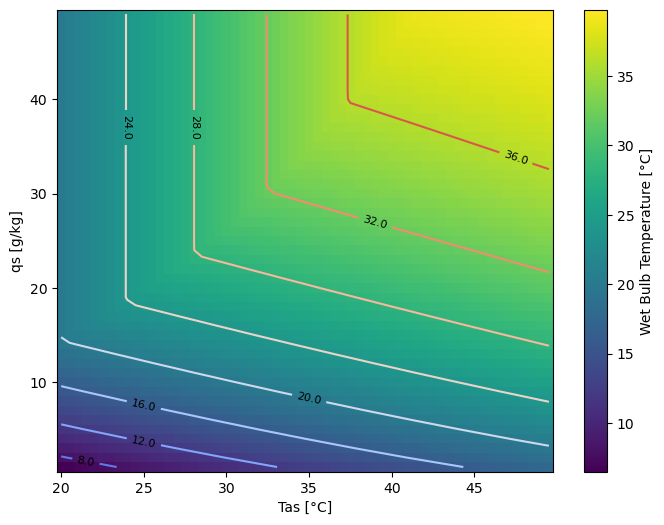

In [52]:

Tw_da = xr.DataArray(Tw_arr.data, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [53]:
Tw_da_hsi = Tw_da

# Compare NEWT - HSI (Tw)

HSI is biased cold at high Tw values?? and some differences around the 100% RH line 

<a list of 9 text.Text objects>

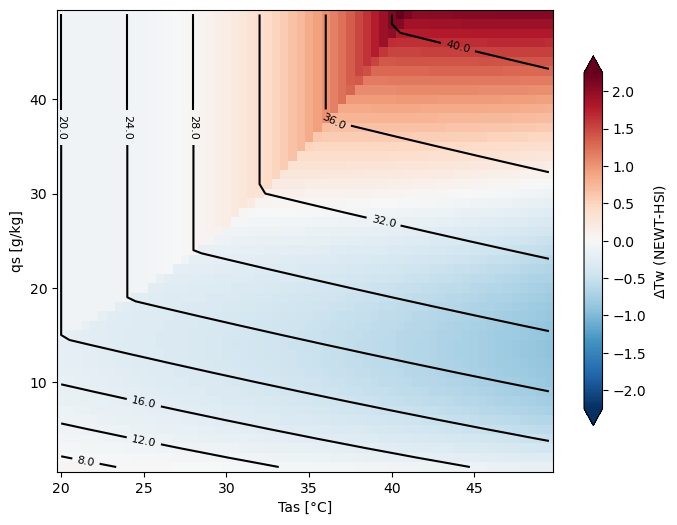

In [54]:
fig, ax = plt.subplots(figsize=(8, 6))

(Tw_da_adiabatic - Tw_da_hsi).plot( cbar_kwargs={"label": "$\Delta$Tw (NEWT-HSI)", 'extend':'both', 'shrink':0.8} ) # difference

contours = ax.contour(Tw_da_adiabatic.Tas, Tw_da_adiabatic.qs, Tw_da_adiabatic.values, levels=10, colors='k')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black') # WBGT values (NEWT)


# look at colder temperatures

## 1. NEWT

In [93]:
p = 1000 * 100 # Pascals
T = np.arange(-30,50,0.5) + 273.15 # Kelvin
q = np.arange(0.001, 0.05, 0.001) # kg/kg

len(T), len(q)

(160, 49)

In [94]:
T_arr = np.array([T]*len(q) ) 
T_arr

array([[243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       ...,
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65]])

In [95]:
q_arr = np.array([q]*len(T) ).T
q_arr

array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])

In [96]:
print(q_arr.shape, T_arr.shape)

(49, 160) (49, 160)


<a list of 9 text.Text objects>

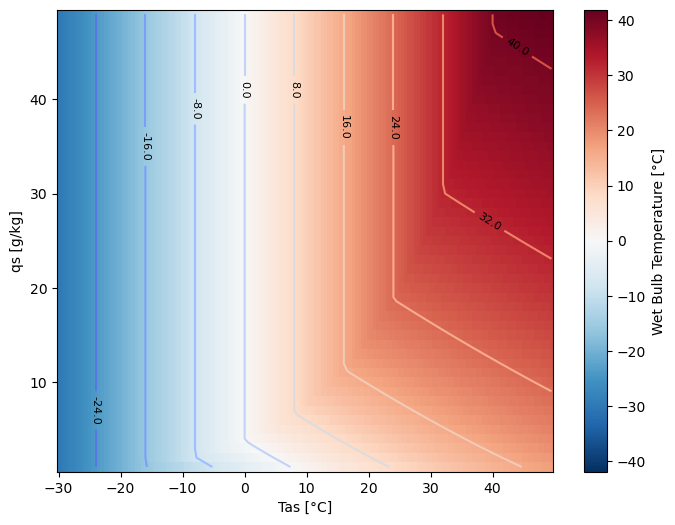

In [97]:
Tw_arr = thermo.wet_bulb_temperature(p,T_arr,q_arr, saturation ='pseudo') - 273.15

Tw_da = xr.DataArray(Tw_arr, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [98]:
Tw_da_adiabatic = Tw_da

In [99]:

WBGT_da = Tw_da*0.7 +Tw_da.Tas*0.3
WBGT_da.attrs['units'] = '°C'
WBGT_da.name='indoor WBGT'
WBGT_da

<xarray.DataArray 'indoor WBGT' (qs: 49, Tas: 160)>
array([[-30.00100069, -29.5009713 , -29.00093514, ...,  26.56960496,
         26.82490193,  27.07948839],
       [-30.00100069, -29.5009713 , -29.00093514, ...,  27.25334344,
         27.50529693,  27.75657143],
       [-30.00100069, -29.5009713 , -29.00093514, ...,  27.89316865,
         28.14214432,  28.3904661 ],
       ...,
       [-30.00100069, -29.5009713 , -29.00093514, ...,  43.3166142 ,
         43.5132616 ,  43.70970406],
       [-30.00100069, -29.5009713 , -29.00093514, ...,  43.53786603,
         43.73399918,  43.92992866],
       [-30.00100069, -29.5009713 , -29.00093514, ...,  43.7560457 ,
         43.95167797,  44.14710736]])
Coordinates:
  * qs       (qs) float64 1.0 2.0 3.0 4.0 5.0 6.0 ... 45.0 46.0 47.0 48.0 49.0
  * Tas      (Tas) float64 -30.0 -29.5 -29.0 -28.5 -28.0 ... 48.0 48.5 49.0 49.5
Attributes:
    units:    °C

In [100]:
WBGT_da_adiabatic = WBGT_da

<a list of 9 text.Text objects>

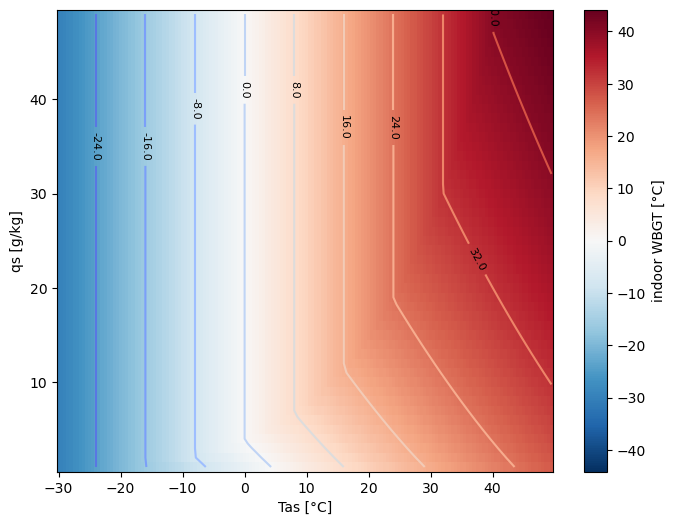

In [101]:

fig, ax = plt.subplots(figsize=(8, 6))


WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.qs, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


# save this fig and put in SI

## 2. HSI

In [102]:
T_arr = xr.DataArray([T]*len(q) )
T_arr

<xarray.DataArray (dim_0: 49, dim_1: 160)>
array([[243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       ...,
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65],
       [243.15, 243.65, 244.15, ..., 321.65, 322.15, 322.65]])
Dimensions without coordinates: dim_0, dim_1

In [103]:
q_arr = xr.DataArray(np.array([q]*len(T)).T )
q_arr

<xarray.DataArray (dim_0: 49, dim_1: 160)>
array([[0.001, 0.001, 0.001, ..., 0.001, 0.001, 0.001],
       [0.002, 0.002, 0.002, ..., 0.002, 0.002, 0.002],
       [0.003, 0.003, 0.003, ..., 0.003, 0.003, 0.003],
       ...,
       [0.047, 0.047, 0.047, ..., 0.047, 0.047, 0.047],
       [0.048, 0.048, 0.048, ..., 0.048, 0.048, 0.048],
       [0.049, 0.049, 0.049, ..., 0.049, 0.049, 0.049]])
Dimensions without coordinates: dim_0, dim_1

In [104]:
# calculate relative humidity from specific
e,RH = hsi.get_humidity(q_arr, p, T_arr) # kg/kg, Pa, K 


In [105]:
# wet bulb temperature
Tw_arr = hsi.WBT_DavJon(T_arr, RH, p)

In [106]:
# wet bulb globe temperature
WBGT = hsi.WBGT(T_arr, RH, p)

<a list of 8 text.Text objects>

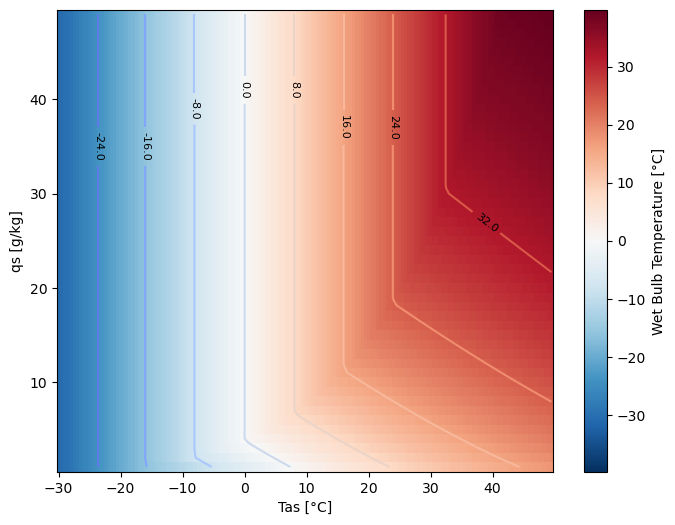

In [107]:
Tw_da = xr.DataArray(Tw_arr.data, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
Tw_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.Tas, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


<a list of 9 text.Text objects>

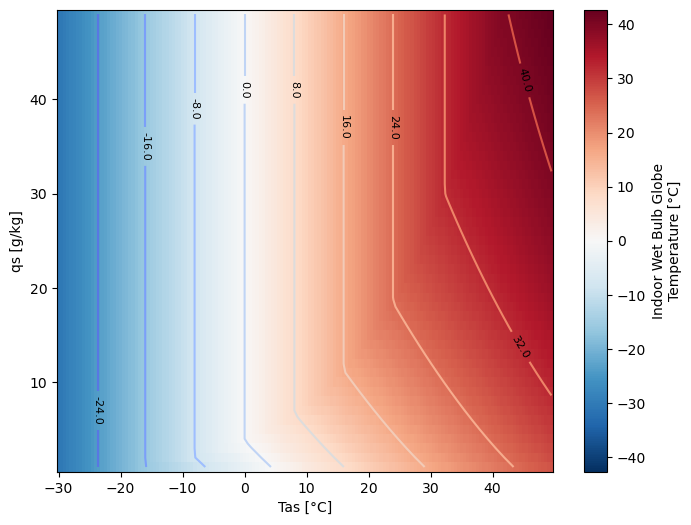

In [111]:
WBGT_da = xr.DataArray(WBGT.data, coords=[ ('qs', q*1000), ('Tas', T-273.15)], name="Indoor Wet Bulb Globe Temperature")
WBGT_da.attrs['units'] = '°C'
WBGT_da.coords['qs'].attrs['units'] = 'g/kg'  # Specific Humidity units
WBGT_da.coords['Tas'].attrs['units'] = '°C'   # Temperature units

fig, ax = plt.subplots(figsize=(8, 6))


WBGT_da.plot(ax =ax )
contours = ax.contour(WBGT_da.Tas, WBGT_da.qs, WBGT_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed



In [112]:
WBGT_hsi = WBGT_da

In [113]:
Tw_hsi = Tw_da

## compare

<a list of 9 text.Text objects>

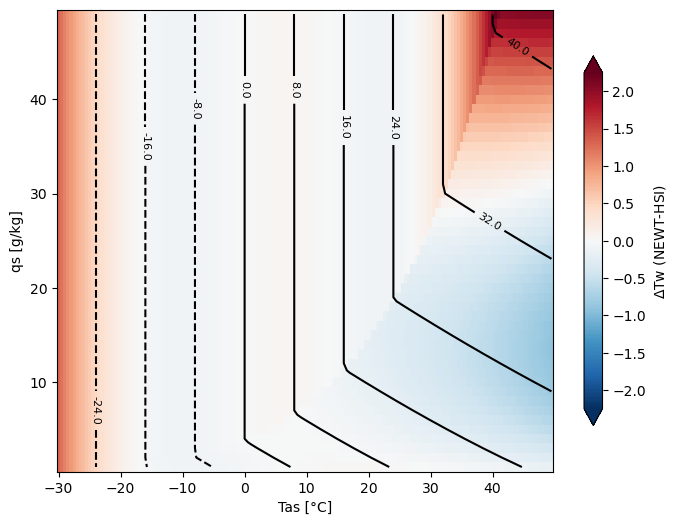

In [115]:
fig, ax = plt.subplots(figsize=(8, 6))

data = Tw_da_adiabatic - Tw_hsi

data.plot( cbar_kwargs={"label": "$\Delta$Tw (NEWT-HSI)", 'extend':'both', 'shrink':0.8} ) # difference

contours = ax.contour(Tw_da_adiabatic.Tas, Tw_da_adiabatic.qs, Tw_da_adiabatic.values, levels=10, colors='k')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black') # WBGT values (NEWT)


In [116]:
data.min(), data.max()

(<xarray.DataArray 'Wet Bulb Temperature' ()>
 array(-0.90026484),
 <xarray.DataArray 'Wet Bulb Temperature' ()>
 array(2.24874885))

<a list of 9 text.Text objects>

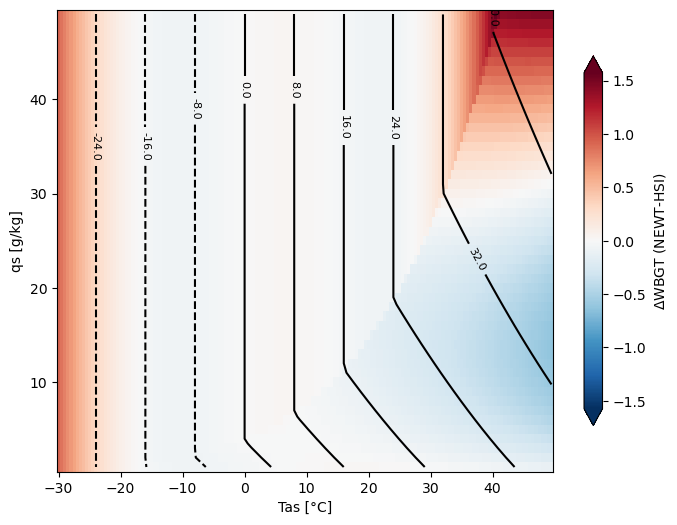

In [120]:
fig, ax = plt.subplots(figsize=(8, 6))

data = WBGT_da_adiabatic - WBGT_hsi

data.plot( cbar_kwargs={"label": "$\Delta$WBGT (NEWT-HSI)", 'extend':'both', 'shrink':0.8} ) # difference

contours = ax.contour(WBGT_da_adiabatic.Tas, WBGT_da_adiabatic.qs, WBGT_da_adiabatic.values, levels=10, colors='k')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black') # WBGT values (NEWT)


In [119]:
data.min(), data.max()

(<xarray.DataArray ()>
 array(-0.63018424),
 <xarray.DataArray ()>
 array(1.57412381))

## Vary pressure and qs and keep T constant (cold place like Himalayas)

In [232]:
#p = 1000 * 100 # Pascals
#T = np.arange(-30,50,0.5) + 273.15 # Kelvin

p = np.arange(500,1000,10) * 100 # Pascals
T = 0 + 273.15 # Kelvin (cold place!)
q = np.arange(0.0001, 0.02, 0.001) # kg/kg 

print(len(p), len(q))

p_arr = np.array([p]*len(q) ) 
q_arr = np.array([q]*len(p) ).T


50 20


In [233]:
Tw_arr = thermo.wet_bulb_temperature(p_arr,T,q_arr, saturation ='pseudo') - 273.15
Tw_arr.shape

(20, 50)

<a list of 11 text.Text objects>

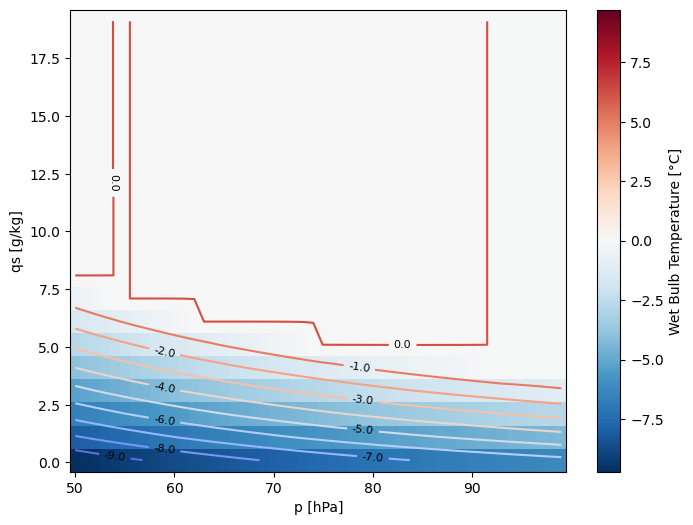

In [234]:
Tw_da = xr.DataArray(Tw_arr.data, coords=[ ('qs', q*1000), ('p', p/100)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['p'].attrs['units'] = 'hPa'  # Specific Humidity units
Tw_da.coords['qs'].attrs['units'] = 'g/kg'   # Temperature units

Tw_da_newt = Tw_da 

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.p, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [243]:
Tw_da_newt.max()

<xarray.DataArray 'Wet Bulb Temperature' ()>
array(0.00793176)

In [245]:
Tw_da_newt.min()

<xarray.DataArray 'Wet Bulb Temperature' ()>
array(-9.70694191)

In [235]:
# cfr with HSI

# calculate relative humidity from specific
e,RH = hsi.get_humidity(xr.DataArray(q_arr), xr.DataArray(p_arr), T) # kg/kg, Pa, K 
# wet bulb temperature
Tw_arr = hsi.WBT_DavJon(T, RH, xr.DataArray(p_arr))
# wet bulb globe temperature
WBGT = hsi.WBGT(T, RH, xr.DataArray(p_arr))

<a list of 10 text.Text objects>

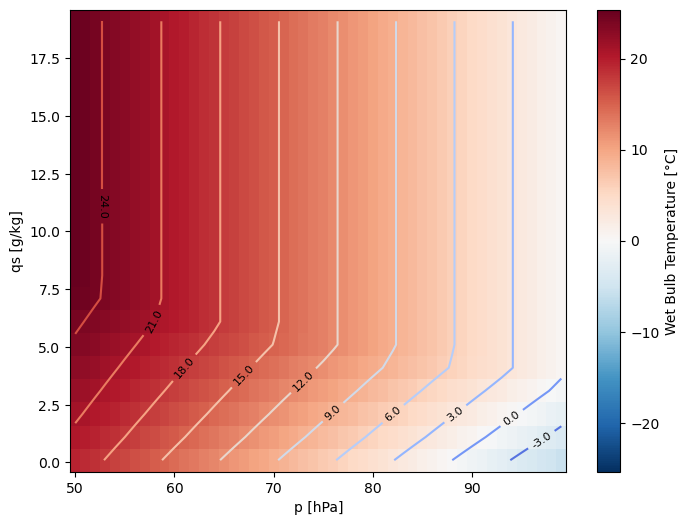

In [236]:
Tw_da = xr.DataArray(Tw_arr.data, coords=[ ('qs', q*1000), ('p', p/1000)], name="Wet Bulb Temperature")
Tw_da.attrs['units'] = '°C'
Tw_da.coords['p'].attrs['units'] = 'hPa'  # Specific Humidity units
Tw_da.coords['qs'].attrs['units'] = 'g/kg'   # Temperature units

Tw_da_hsi = Tw_da 

fig, ax = plt.subplots(figsize=(8, 6))


Tw_da.plot(ax =ax )
contours = ax.contour(Tw_da.p, Tw_da.qs, Tw_da.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed


In [244]:
Tw_da_hsi.max()

<xarray.DataArray 'Wet Bulb Temperature' ()>
array(25.36322975)

Text(0.5, 1.0, 'NEWT - HSI at 0 deg C')

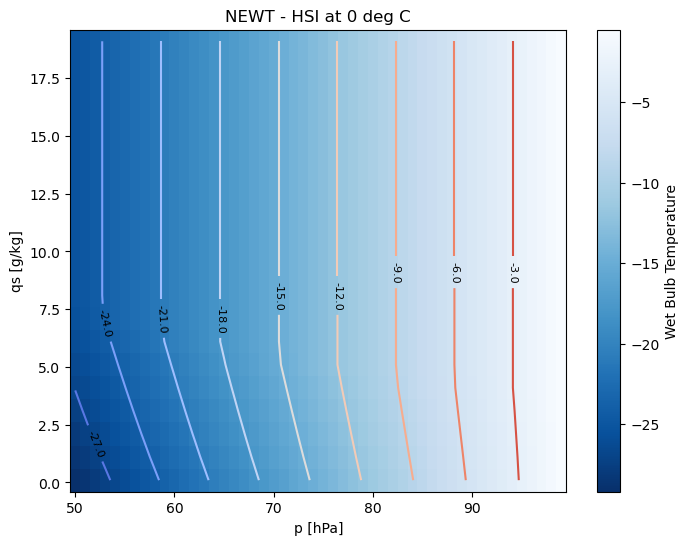

In [253]:

fig, ax = plt.subplots(figsize=(8, 6))


data = (Tw_da_newt - Tw_da_hsi)
data.plot(ax =ax,cmap='Blues_r')
contours = ax.contour(data.p, data.qs, data.values, levels=10, cmap='coolwarm')
ax.clabel(contours, inline=True, fontsize=8, fmt='%1.1f', colors='black')  # Adjust the format as needed
plt.title('NEWT - HSI at 0 deg C')

In [252]:
data.min(),data.max()

(<xarray.DataArray 'Wet Bulb Temperature' ()>
 array(-29.19424851),
 <xarray.DataArray 'Wet Bulb Temperature' ()>
 array(-0.51132006))

## Compare on a day of data 

In [122]:
from utils import *

In [129]:
GCM = GCMs[0]
dir1, dir2 = get_dirpaths(GCM, 'historical', 'ssp370')
variables = VARs=['tasmax','huss', 'ps']
filepaths = [get_filepaths(VAR,dir1) for VAR in variables]
#filepaths

['/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_ps_global_daily_1850_1850.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_ps_global_daily_1851_1860.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_ps_global_daily_1861_1870.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_ps_global_daily_1871_1880.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5

In [130]:
tasmax,huss,ps= [xr.open_dataarray(files[-1]) for files in filepaths]

In [131]:
tasmax

<xarray.DataArray 'tasmax' (time: 1461, lat: 360, lon: 720)>
[378691200 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 2011-01-01 2011-01-02 ... 2014-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K

In [170]:
time = 0

ps = ps.isel(time=time)
tasmax = tasmax.isel(time=time)
huss= huss.isel(time=time)

ps_arr = ps.values.astype(float)
tasmax_arr = tasmax.values.astype(float)
huss_arr = huss.values.astype(float)


Tw = thermo.wet_bulb_temperature(ps_arr, tasmax_arr, huss_arr, saturation ='pseudo')

Tw_da_newt = xr.DataArray(Tw, coords=[ ('lat', tasmax.lat.values), ('lon',tasmax.lon.values)], name="Wet Bulb Temperature")

WBGT_da_newt = ((Tw_da_newt*0.7 + tasmax_arr*0.3)-273.15).rename('Indoor Wet Bulb Globe Temperature')

Tw_da_newt = Tw_da_newt -273.15

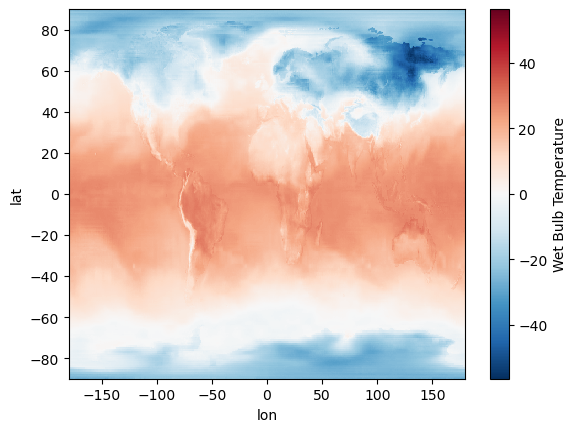

In [171]:
Tw_da_newt.plot()

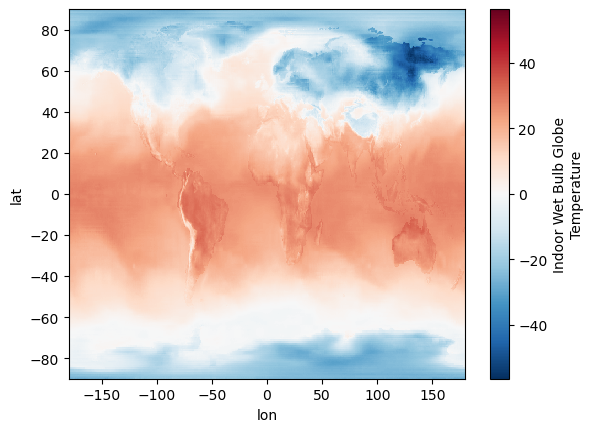

In [172]:
WBGT_da_newt.plot()

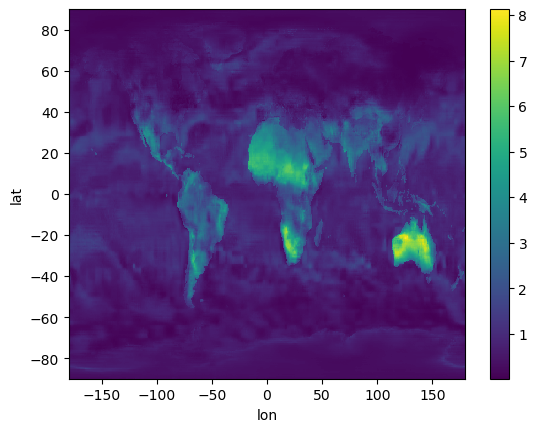

In [173]:
(WBGT_da_newt - Tw_da_newt).plot()

In [175]:
# HSI based one 

# calculate relative humidity from specific
e,RH = hsi.get_humidity(huss, ps, tasmax) # kg/kg, Pa, K 
# wet bulb temperature
Tw_arr = hsi.WBT_DavJon(tasmax, RH, ps)
# wet bulb globe temperature
WBGT = hsi.WBGT(tasmax, RH, ps)

In [176]:
WBGT_hsi = WBGT
TW_hsi = Tw_arr

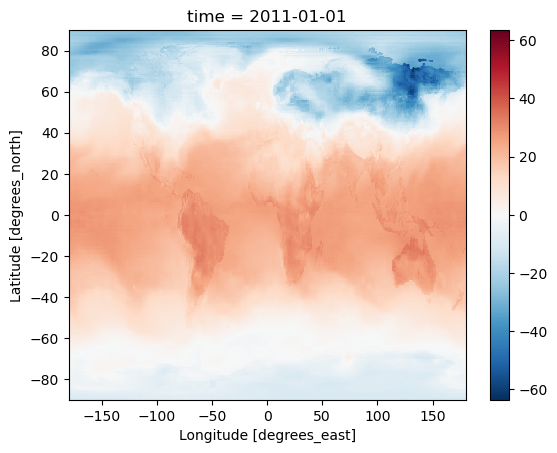

In [177]:
WBGT_hsi.plot()

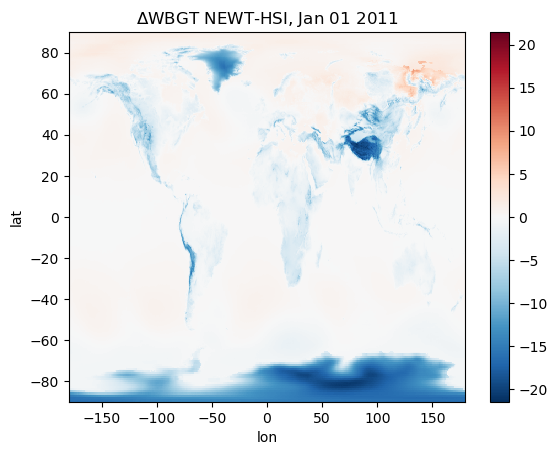

In [259]:
(WBGT_da_newt - WBGT_hsi).plot()
plt.title('$\Delta$WBGT NEWT-HSI, Jan 01 2011');

In [181]:
lonmin,latmin,lonmax,latmax=69.2,23.29,107.87,41.95

ps_sel = ps.sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax))
tasmax_sel = tasmax.sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax))
huss_sel= huss.sel(lat=slice(latmax,latmin),lon=slice(lonmin,lonmax))

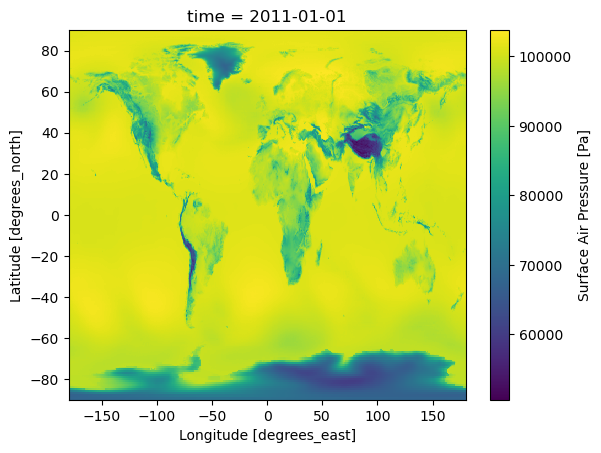

In [185]:
ps.plot()

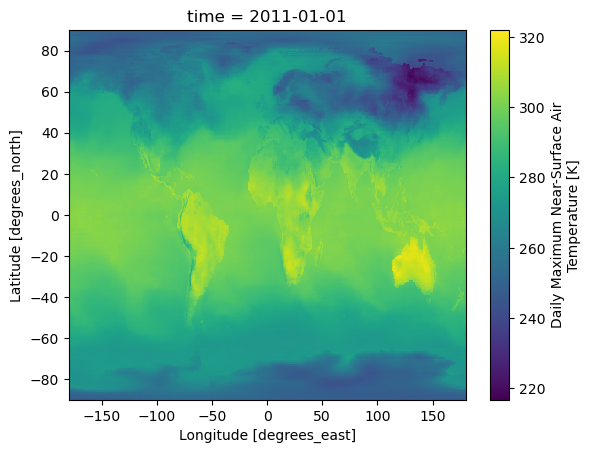

In [186]:
tasmax.plot()

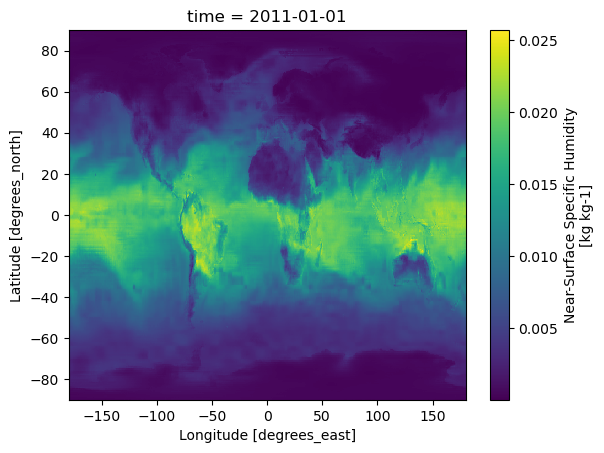

In [187]:
huss.plot()

50581.10546875 101495.4609375


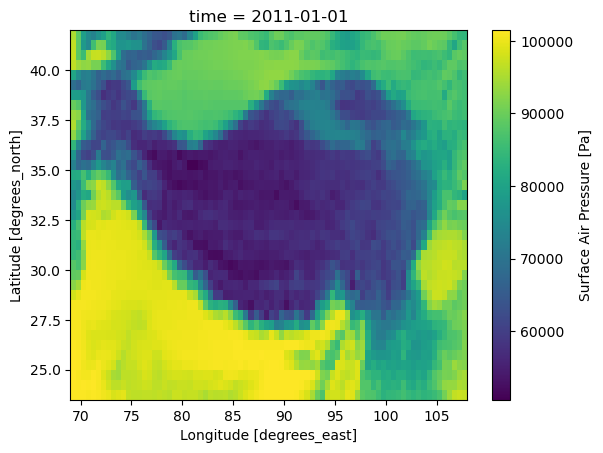

In [209]:
ps_sel.plot()
print(ps_sel.min().values, ps_sel.max().values)

261.197998046875 304.83935546875


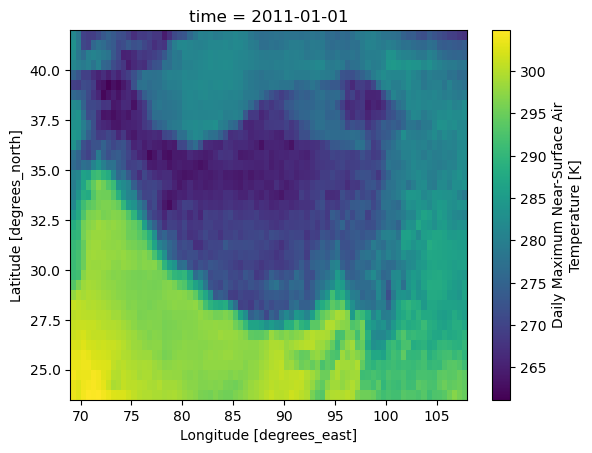

In [210]:
tasmax_sel.plot()
print(tasmax_sel.min().values, tasmax_sel.max().values)

0.00026240263832733035 0.013024521060287952


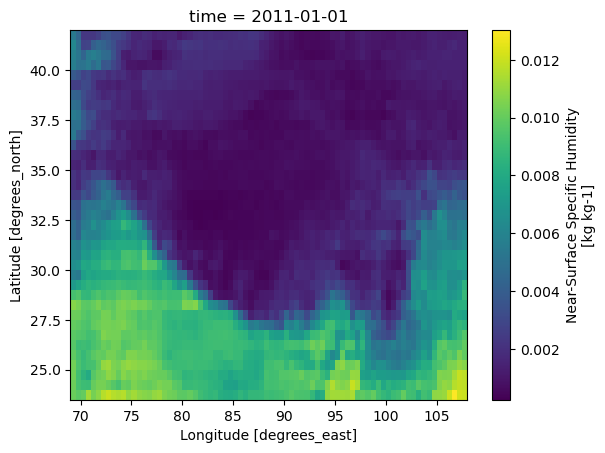

In [211]:
huss_sel.plot()
print(huss_sel.min().values, huss_sel.max().values)

In [214]:
261-273.15


-12.149999999999977